In [1]:
run ../initialize.ipynb

ImportError: cannot import name 'units'

ImportError: cannot import name 'units'

In [2]:
import scipy
plt.style.use('luca')

In [3]:
def get_file_list(path, pattern, remove_string='', remove_path=True):
    '''
    Get a list of files matching pattern in path. Optional to remove a part of the path (i.e. the extention)
    Optional to remove the path
    '''
    file_list = glob.glob(path + pattern)
    # Remove path
    for i, f in enumerate(file_list):
        if remove_path:
            f = f.replace(path, '')
        if remove_string != '':
            f = f.replace(remove_string, '')
        file_list[i] = f
    file_list = np.sort(file_list)
    return file_list


### Find and load SR0 Datasets

In [ ]:
datasets = hax.runs.datasets 
datasets = hax.runs.tags_selection(include=['*sciencerun0'],
                                  exclude=['bad','messy', 'test',
                                           'nofield','lowfield',
                                           'commissioning', 'flash',
                                           'pmttrip','trip','_pmttrip',
                                           'source_opening',
                                           ],
                                  )
datasets= hax.cuts.selection(datasets, datasets['location'] != '', 'Processed data available')

#Radon
datasets_rn = hax.cuts.selection(datasets, datasets['source__type']=='Rn220', 'Source in place')
dataset_names_rn = datasets_rn['name']

#Bkg
datasets_bkg = hax.cuts.selection(datasets, datasets['source__type']=='none', 'Source in place')
dataset_names_bkg = datasets_bkg['name']

#Krypton
datasets_kr = hax.cuts.selection(datasets, datasets['source__type']=='Kr83m', 'Source in place')
dataset_names_kr = datasets_kr['name']


In [ ]:
%%time
print('Searching for Processed Pickle Files')
#simpath= '/project/lgrandi/jpienaar/cache_files/'
simpath= '/scratch/midway2/jpienaar/cache_files/'

#Find datasets
datasets = get_file_list(simpath, '*dt.pkl', ' ')
print('Found %d datasets' % len(datasets))

processed_list=[]
for dataset in tqdm(datasets):
    with open(simpath+dataset, 'rb') as handle:
        data_temp = pickle.load(handle)
        try:
            version=data_temp['version']
            if version == '2.0':
                processed_list.append(dataset)
        except KeyError:
            continue
print("Found %i processed files " %len(processed_list))
datasets=processed_list

dicts_datasets_rn={}
duration_rn=0
events_rn=0
dicts_datasets_kr={}
duration_kr=0
events_kr=0
dicts_datasets_bkg={}
duration_bkg=0
events_bkg=0
for dataset in tqdm(datasets[:]):
    key=dataset[:-7]
    if dataset_names_rn.isin([dataset[:-7]]).any():
        with open(simpath+dataset, 'rb') as handle:
            data_dict = pickle.load(handle)
            dataset_temp = datasets_rn.loc[datasets_rn.name==dataset[:-7]]
            time_diff=dataset_temp.end-dataset_temp.start
            data_dict['duration'] =  time_diff.iloc[0].seconds
            duration_rn+=time_diff.iloc[0].seconds
            events_rn+=dataset_temp.iloc[0].trigger__events_built
        dicts_datasets_rn[key]=data_dict
              
    elif dataset_names_kr.isin([dataset[:-7]]).any():
        with open(simpath+dataset, 'rb') as handle:
            data_dict = pickle.load(handle)
            dataset_temp = datasets_kr.loc[datasets_kr.name==dataset[:-7]]
            time_diff=dataset_temp.end-dataset_temp.start
            data_dict['duration'] =  time_diff.iloc[0].seconds
            duration_kr+=time_diff.iloc[0].seconds
            events_kr+=dataset_temp.iloc[0].trigger__events_built
        dicts_datasets_kr[key]=data_dict
        
    elif dataset_names_bkg.isin([dataset[:-7]]).any():
        with open(simpath+dataset, 'rb') as handle:
            data_dict = pickle.load(handle)
            dataset_temp = datasets_bkg.loc[datasets_bkg.name==dataset[:-7]]
            time_diff=dataset_temp.end-dataset_temp.start
            data_dict['duration'] =  time_diff.iloc[0].seconds
            duration_bkg+=time_diff.iloc[0].seconds
            events_bkg+=dataset_temp.iloc[0].trigger__events_built
        dicts_datasets_bkg[key]=data_dict
    
#df_PI=pd.concat(df_PI)

In [ ]:
print("Event Rate Radon:", events_rn/duration_rn)
print("Event Rate Krypton:", events_kr/duration_kr)
print("Event Rate Background:", events_bkg/duration_bkg)

In [ ]:
dict_source_sr0={'Radon' : dicts_datasets_rn, 'Background' : dicts_datasets_bkg, 'Krypton': dicts_datasets_kr,}
for source, dict_data in dict_source_sr1.items():
    print(source, len(dict_data))

### Find and Load SR1 Datasets

In [54]:
datasets = hax.runs.datasets 
datasets = hax.runs.tags_selection(include=['*sciencerun1'],
                                  exclude=['bad','messy', 'test',
                                           'nofield','lowfield',
                                           'commissioning', 'flash',
                                           'pmttrip','trip','_pmttrip',
                                           'source_opening',
                                           ],
                                  )
datasets= hax.cuts.selection(datasets, datasets['location'] != '', 'Processed data available')

#Radon
datasets_rn = hax.cuts.selection(datasets, datasets['source__type']=='Rn220', 'Source in place')
dataset_names_rn = datasets_rn['name']

#Bkg
datasets_bkg = hax.cuts.selection(datasets, datasets['source__type']=='none', 'Source in place')
dataset_names_bkg = datasets_bkg['name']

#Krypton
datasets_kr = hax.cuts.selection(datasets, datasets['source__type']=='Kr83m', 'Source in place')
dataset_names_kr = datasets_kr['name']


Processed data available selection: 0 rows removed (100.00% passed)
Source in place selection: 7229 rows removed (4.56% passed)
Source in place selection: 1185 rows removed (84.35% passed)
Source in place selection: 7119 rows removed (6.01% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


In [58]:
%%time
print('Searching for Processed Pickle Files')
simpath= '/project/lgrandi/jpienaar/cache_files/cache_files/'
#simpath= '/scratch/midway2/jpienaar/cache_files/'

#Find datasets
datasets = get_file_list(simpath, '*dt.pkl', ' ')
print('Found %d datasets' % len(datasets))

processed_list=[]
for dataset in tqdm(datasets):
    with open(simpath+dataset, 'rb') as handle:
        data_temp = pickle.load(handle)
        try:
            version=data_temp['version']
            if version == '2.0':
                processed_list.append(dataset)
        except KeyError:
            continue
print("Found %i processed files " %len(processed_list))
datasets=processed_list

dicts_datasets_rn={}
duration_rn=0
events_rn=0
dicts_datasets_kr={}
duration_kr=0
events_kr=0
dicts_datasets_bkg={}
duration_bkg=0
events_bkg=0
for dataset in tqdm(datasets[:]):
    key=dataset[:-7]
    if dataset_names_rn.isin([dataset[:-7]]).any():
        with open(simpath+dataset, 'rb') as handle:
            data_dict = pickle.load(handle)
            dataset_temp = datasets_rn.loc[datasets_rn.name==dataset[:-7]]
            time_diff=dataset_temp.end-dataset_temp.start
            data_dict['duration'] =  time_diff.iloc[0].seconds
            duration_rn+=time_diff.iloc[0].seconds
            events_rn+=dataset_temp.iloc[0].trigger__events_built
        dicts_datasets_rn[key]=data_dict
              
    elif dataset_names_kr.isin([dataset[:-7]]).any():
        with open(simpath+dataset, 'rb') as handle:
            data_dict = pickle.load(handle)
            dataset_temp = datasets_kr.loc[datasets_kr.name==dataset[:-7]]
            time_diff=dataset_temp.end-dataset_temp.start
            data_dict['duration'] =  time_diff.iloc[0].seconds
            duration_kr+=time_diff.iloc[0].seconds
            events_kr+=dataset_temp.iloc[0].trigger__events_built
        dicts_datasets_kr[key]=data_dict
        
    elif dataset_names_bkg.isin([dataset[:-7]]).any():
        with open(simpath+dataset, 'rb') as handle:
            data_dict = pickle.load(handle)
            dataset_temp = datasets_bkg.loc[datasets_bkg.name==dataset[:-7]]
            time_diff=dataset_temp.end-dataset_temp.start
            data_dict['duration'] =  time_diff.iloc[0].seconds
            duration_bkg+=time_diff.iloc[0].seconds
            events_bkg+=dataset_temp.iloc[0].trigger__events_built
        dicts_datasets_bkg[key]=data_dict
    
#df_PI=pd.concat(df_PI)

Searching for Processed Pickle Files


  0%|          | 0/5707 [00:00<?, ?it/s]

Found 5707 datasets


  1%|▏         | 83/5702 [00:00<00:06, 822.55it/s]

Found 5702 processed files 


100%|██████████| 5702/5702 [04:40<00:00, 20.31it/s] 

CPU times: user 1min 12s, sys: 1min 37s, total: 2min 49s
Wall time: 21min 9s


In [ ]:
print("Event Rate Radon:", events_rn/duration_rn)
print("Event Rate Krypton:", events_kr/duration_kr)
print("Event Rate Background:", events_bkg/duration_bkg)

In [59]:
dict_source_sr1={'Radon' : dicts_datasets_rn, 'Background' : dicts_datasets_bkg, 'Krypton': dicts_datasets_kr,}
for source, dict_data in dict_source_sr1.items():
    print(source, len(dict_data))

Krypton 297
Radon 200
Background 2057


### Make 1d Histograms of Initial S2 Size

In [ ]:
##Live Time Corrected 2d Plots##
#plt.figure(figsize=(10, 8))
index=0
_xmax=10**8
_tpoints=np.linspace(0, _xmax, 201)
_xmin=_tpoints[1]
_ymax=1.7e-7
livet_hist=0
events=0
plt.set_cmap("Oranges")

_s2bins=50
_tbins=200
sampling_dict={}
events_hist=0
for source, dict_data in dict_source_sr1.items():
    print(source, len(dict_data))
    plt.figure(figsize=(10, 8))
    del events_hist
    #del livet_hist
    events=0
    duration=0
    for key, data in dict_data.items():
        try:
            events_hist
            events_hist+=data['deltat']
            events+=data['events']
            duration+=data['duration']
        except NameError:
            events_hist=data['deltat']
            events=data['events']
            duration=data['duration']
    
      
                
    print("Event Rate: %.2f" %(events/duration))
    
    events_hist=events_hist.sum("delta_T")
    events_hist.plot()    
    plt.xlabel('Time Since S2 [ns]', fontsize=12)
    plt.ylabel('S2 Size [Log10(PE)]', fontsize=12)
    #plt.savefig("fig_%s_2d_rate_corrected.png" %source, bboxes='tight')
    #plt.savefig("fig_%s_2d_rate_corrected.pdf" %source, bboxes='tight')
    plt.show()    

    sampling_dict[source]={'hist': events_hist, 'event_rate' :events/duration} 
    
   
    #new_hist.plot(label=source, color=colours[index])
    #index+=1


In [ ]:
with open('s2_spectrum_per_source_sr1.pkl', 'wb') as handle:
    pickle.dump(sampling_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### 1D Rate Histograms

Krypton
47392248
Radon
20697469
Background
42888011


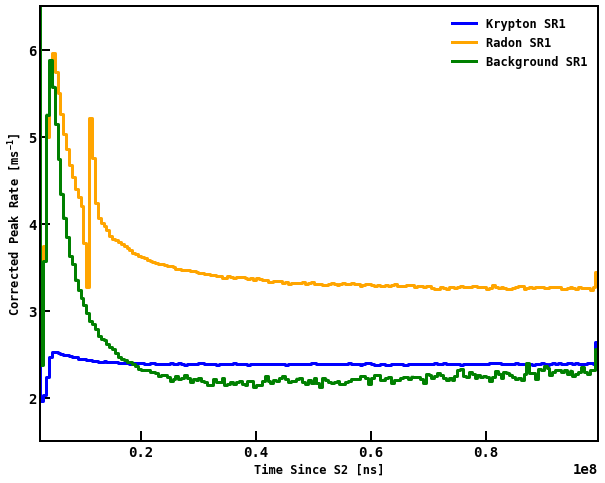

In [68]:
#Plots corrected event with error added#
colours=['blue', 'orange', 'green', 'magenta', 'cyan', 'red']
plt.figure(figsize=(10, 8))
index=0
window_length=10**8
_tpoints=np.linspace(0, window_length, 201)
_xmin=_tpoints[1]
_ymax=1.7e-7
events_hist=0
events=0
index=0

data_hists_dict={}
for source, dict_data in dict_source_sr1.items():
    print(source)
    del events_hist
    #del livet_hist
    events=0
    for key, data in dict_data.items():
        try:
            events_hist
            events_hist+=data['deltat']
            weight_hist+=data['deltat_weights']
            livet_hist+=data['livet_hist']
            livet_weight+=data['livet_weights']
            events+=data['events']
        except NameError:
            events_hist=data['deltat']
            weight_hist=data['deltat_weights']
            livet_hist=data['livet_hist']
            livet_weight=data['livet_weights']
            events=data['events']
        except KeyError:
            print(source, key)
        
    events_hist=events_hist.sum('s2_area')
    weight_hist=weight_hist.sum('s2_area')
    livet_hist=livet_hist.sum('s2_area')
    livet_weight=livet_weight.sum('s2_area')
    
    #Error
    num_value=np.array(events_hist)
    denum_value=np.array(livet_hist)
    num_error = np.sqrt(weight_hist)
    denum_error = np.sqrt(livet_weight)
    e1 = num_error
    e2 = denum_error
    b1 = num_value
    b2 = denum_value
    w=b1/b2
    
    ratio_error = np.abs(((1-2*w)*e1*e1 + w*w*e2*e2)/(b2*b2))       
    ratio = num_value/denum_value 
    
    #Confidence Bands
    x = _tpoints
    x = np.sort(np.array(list(x[1:]) + list(x[:-1])))
    y1=ratio-np.sqrt(ratio_error)
    y2=ratio+np.sqrt(ratio_error)
    y_lower = np.repeat(y1[:], 2)
    y_upper = np.repeat(y2[:], 2)
        
    #Plot
    plt.step(_tpoints[1:], ratio*1000000, linewidth=3,  color=colours[index], label=source+' SR1')
    plt.fill_between(x, y_lower*1000000, y_upper*1000000, facecolor=colours[index], interpolate=True, alpha = 0.25)
    index+=1
    #data_hists_dict[source] = {'rate' : ratio*1000000, 'lower' : y_lower*1000000, 'upper' : y_upper*1000000}
    data_hists_dict[source] = {'rate' : ratio*1000000, 'lower' : y1*1000000, 'upper' : y2*1000000}
    print(events)

plt.xlim([_tpoints[5], _tpoints[-2]])
plt.ylim([1.5, 6.5])
plt.xlabel('Time Since S2 [ns]', fontsize=12)
plt.ylabel('Corrected Peak Rate [ms$^{-1}$]', fontsize=12)
axes = plt.gca()
axes.tick_params(width=2, length=10)
plt.legend(loc='best', fontsize=12)
#plt.yscale('log')
plt.show()

In [69]:
with open('sr1_se_rate.pkl', 'wb') as handle:
    pickle.dump(data_hists_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Define MC


In [4]:
#Load SE Rate histograms:
with open('sr1_se_rate.pkl', 'rb') as handle:
    data_hists_dict = pickle.load(handle)

In [5]:
#Load S2 size histograms:
with open('s2_spectrum_per_source_sr1.pkl', 'rb') as handle:
    sampling_dict = pickle.load(handle)

In [6]:
def rate_function(scaling_constant, time_scale, dt_bins):
    y = scaling_constant*np.exp(-dt_bins/time_scale)
    return (y)


def se_histogram(event_rate, # Number of events assumed to occur within 1s
                 background_rate, # Flat background rate of Single Electrons 
                 time_scale, # Time Scale of exponential decay of trapped electrons
                 scaling_constant, #Fraction of electrons relative to S2 size 
                 source = 'Background', # Primary S2 spectrum for sampling from
                 time_bins=100, # Number of bins in time
                 window_length=1000 #Length after given S2 to look at
                ):
    
    #Determine number of events in timw window
    number_of_events = np.random.poisson(event_rate) #Event rate in window....
    
    #Assign random times to S2s in window following S2, leaving first S2 at t=0 
    if number_of_events>1:
        time_of_s2s=np.random.random(number_of_events-1)
        time_of_s2s=np.concatenate(([0], time_of_s2s))
    else:
        number_of_events = 1
        time_of_s2s=np.array([0])
    
    bin_width=window_length/time_bins
    
    #Sample from Appropriate S2 Size Spectrum (produced previously)
    s2_spectrum_hist = sampling_dict[source]['hist']    
    s2_size = np.random.choice(s2_spectrum_hist.bin_centers, 
                               number_of_events, 
                               p =(s2_spectrum_hist[:])/np.sum(s2_spectrum_hist[:]))
    s2_size=10**s2_size
    
    #Initialize Arrays of SE rate
    se_rate=[background_rate]*time_bins
    dt_bins=np.linspace(0, window_length, time_bins+1)
    
    #print(s2_size)
    
    for is2, s2 in enumerate(time_of_s2s):
        s2 = s2 * window_length # Span window length, assumed to be in ms
        bin_offset = np.digitize(s2, dt_bins) 
        counts = rate_function(scaling_constant = scaling_constant*s2_size[is2], 
                               time_scale=time_scale, 
                               dt_bins=dt_bins)
        event_len =  time_bins-bin_offset
        zero_array = np.array([0]*int(bin_offset))
        counts = np.concatenate((np.array(zero_array), counts[:event_len]))
        se_rate += counts
    
    dt_bin_centers = dt_bins[1:]-(dt_bins[1:]-dt_bins[:-1])/2
    
    return dt_bin_centers, se_rate   

  6%|▋         | 648/10000 [00:00<00:01, 6477.26it/s]

5.935457875153676


  4%|▍         | 401/10000 [00:00<00:02, 4005.71it/s]

50.55552565635856


  6%|▌         | 552/10000 [00:00<00:01, 5517.56it/s]

25.968395072155708


100%|██████████| 10000/10000 [00:01<00:00, 5191.43it/s]


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


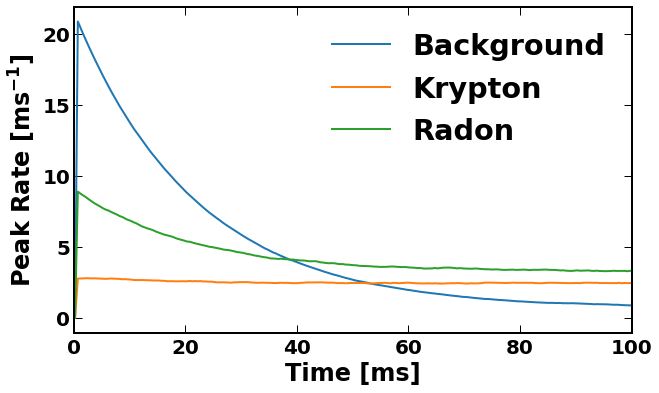

In [75]:
### Plot Models of All Sources With Same Parameters

fig = plt.figure(figsize=(10, 6))

waveforms = 10000
time_bins = 200
window_length=100

dict_mc_known={}
for source, hist_dict in sampling_dict.items():
    
    x_bins = [0]*time_bins
    y_bins = [0]*time_bins
    
    source_rate = hist_dict['event_rate']
    print(source_rate)

    event_rate = source_rate*window_length/1000 #Event rate in s, window length in ms
    
    for sim in tqdm(range(waveforms)):
        dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                               background_rate=0, 
                                               time_scale = 21.5,
                                               scaling_constant = 5.623e-05, 
                                               
                                               source = source,
                                               time_bins=time_bins,
                                               window_length = window_length)
        y_bins += se_rate
    x_bins = dt_bin_centers
    dict_mc_known[source]=y_bins/waveforms
    plt.plot(x_bins, y_bins/waveforms, label=source)
plt.ylabel("Peak Rate [ms$^{-1}$]")
plt.xlabel("Time [ms]")
plt.xlim([0, window_length])
plt.legend(loc='best')

### Plot for Proposal - December 2018

In [25]:
def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3] 
    subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

def cut_definition(tau, c, s2, electrons):
    time = tau * np.log(c*tau*s2/electrons)
    return time

100%|██████████| 10000/10000 [00:02<00:00, 4868.81it/s]
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


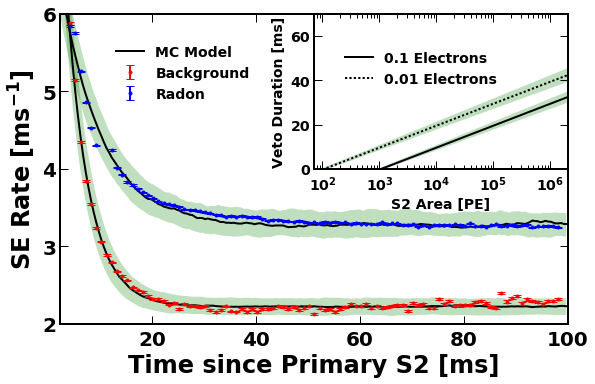

In [99]:
#Plot specific Source data against Model
fig = plt.figure(figsize=(9.1, 5.7))
waveforms = 10000
time_bins = 200
window_length=100
x_bins = [0]*time_bins
y_bins = [0]*time_bins
s2_bins=np.logspace(2, 7, 101)
tau=4.31
c=2.15e-5
plot_start=8
plot_end=198

### Plot Bkg Data and Fit ###
source='Background' 
source_rate = sampling_dict[source]['event_rate']
event_rate = source_rate*window_length/1000 #Event rate in s, window length in ms

#Produce best Fit model
for sim in tqdm(range(waveforms)):
    dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                               background_rate=2.17, 
                                               time_scale = 4.31,
                                               scaling_constant = 2.15e-05, 
                                               
                                               source = source,
                                               time_bins=time_bins,
                                               window_length = window_length)
    y_bins += se_rate
best_fit=y_bins/waveforms

#Plus 1-sigma Model
y_bins = [0]*time_bins
for sim in tqdm(range(waveforms)):
    dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                               background_rate=2.17+0.1, 
                                               time_scale = 4.31+0.25,
                                               scaling_constant = 2.15e-05+0.2e-05, 
                                               
                                               source = source,
                                               time_bins=time_bins,
                                               window_length = window_length)
    y_bins += se_rate
p1sigma=y_bins/waveforms

#Minus 1-sigma Model
y_bins = [0]*time_bins
for sim in tqdm(range(waveforms)):
    dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                               background_rate=2.17-0.1, 
                                               time_scale = 4.31-0.25,
                                               scaling_constant = 2.15e-05-0.2e-05, 
                                               
                                               source = source,
                                               time_bins=time_bins,
                                               window_length = window_length)
    y_bins += se_rate
m1sigma=y_bins/waveforms

x_bins = dt_bin_centers 

# Plot MC Models adn Data
plt.fill_between(x_bins, m1sigma, p1sigma, facecolor='green', interpolate=True, alpha = 0.25)
plt.plot(x_bins, best_fit, label='MC Model', linestyle='-', color='black')
x=x_bins[plot_start:plot_end:2]
y=data_hists_dict[source]['rate'][plot_start:plot_end:2]
yerr_lower=data_hists_dict[source]['lower'][plot_start:plot_end:2]
yerr_upper=data_hists_dict[source]['upper'][plot_start:plot_end:2]
plt.errorbar(x=x, 
             y=y,
             yerr=[y-yerr_lower, yerr_upper-y],
             label='Background', fmt='.',
             color='red')


### Plot Radon Data and Fit ###
source='Radon' 
source_rate = sampling_dict[source]['event_rate']
event_rate = source_rate*window_length/1000 #Event rate in s, window length in ms

#Produce best Fit model
y_bins = [0]*time_bins
for sim in tqdm(range(waveforms)):
    dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                               background_rate=2.68, 
                                               time_scale = 7.9,
                                               scaling_constant = 2.73e-05, 
                                               
                                               source = source,
                                               time_bins=time_bins,
                                               window_length = window_length)
    y_bins += se_rate
best_fit=y_bins/waveforms

#Plus 1-sigma Model
y_bins = [0]*time_bins
for sim in tqdm(range(waveforms)):
    dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                               background_rate=2.68+0.1, 
                                               time_scale = 7.9+0.25,
                                               scaling_constant = 2.73e-05+0.2e-05, 
                                               
                                               source = source,
                                               time_bins=time_bins,
                                               window_length = window_length)
    y_bins += se_rate
p1sigma=y_bins/waveforms

#Minus 1-sigma Model
y_bins = [0]*time_bins
for sim in tqdm(range(waveforms)):
    dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                               background_rate=2.68-0.1, 
                                               time_scale = 7.9-0.25,
                                               scaling_constant = 2.73e-05-0.2e-05, 
                                               
                                               source = source,
                                               time_bins=time_bins,
                                               window_length = window_length)
    y_bins += se_rate
m1sigma=y_bins/waveforms

x_bins = dt_bin_centers 

# Plot MC Models
plt.fill_between(x_bins, m1sigma, p1sigma, facecolor='green', interpolate=True, alpha = 0.25)
plt.plot(x_bins, best_fit, linestyle='-', color='black')
x=x_bins[plot_start:plot_end:2]
y=data_hists_dict[source]['rate'][plot_start:plot_end:2]
yerr_lower=data_hists_dict[source]['lower'][plot_start:plot_end:2]
yerr_upper=data_hists_dict[source]['upper'][plot_start:plot_end:2]
#Remove data points around HEVeto
x=np.append(x[0:6], x[8:])
y=np.append(y[0:6], y[8:])
yerr_lower=np.append(yerr_lower[0:6], yerr_lower[8:])
yerr_upper=np.append(yerr_upper[0:6], yerr_upper[8:])
plt.errorbar(x=x, 
             y=y,
             yerr=[y-yerr_lower, yerr_upper-y],
             label='Radon', fmt='.',
             color='Blue')

#Format Plot
plt.legend(loc = (0.1, 0.7), fontsize=14)
plt.ylim([2,6])
plt.xlim([x_bins[4], 100])
plt.ylabel('SE Rate [ms$^{-1}$]')
plt.xlabel('Time since Primary S2 [ms]')

### Create Subplot for Veto Cut ###
subpos = [0.5,0.5,0.5,0.5] #Position and Dimensions
ax=fig.add_subplot(111)
subax1=add_subplot_axes(ax, subpos)

#Cut 1
electrons=0.1
subax1.plot(s2_bins, cut_definition(tau, c, s2_bins, electrons), linestyle='-', color='black', label= '0.1 Electrons')
subax1.fill_between(s2_bins, 
                    cut_definition(tau-0.25, c-0.2e-05, s2_bins, electrons), 
                    cut_definition(tau+0.25, c+0.2e-05, s2_bins, electrons), 
                    facecolor='green', interpolate=True, alpha = 0.25)

#Cut 2
electrons=0.01
subax1.plot(s2_bins, cut_definition(tau, c, s2_bins, electrons), linestyle=':', color='black', label= '0.01 Electrons')
subax1.fill_between(s2_bins, 
                    cut_definition(tau-0.25, c-0.2e-05, s2_bins, electrons), 
                    cut_definition(tau+0.25, c+0.2e-05, s2_bins, electrons), 
                    facecolor='green', interpolate=True, alpha = 0.25)

#Format Plot
plt.legend(loc=(0.1, 0.5), fontsize=14)
plt.xscale('log')
plt.xlim([70, 2e6])
plt.ylim([0, 70])
plt.ylabel('Veto Duration [ms]', fontsize = 14)
plt.xlabel('S2 Area [PE]', fontsize = 14)

plt.savefig("fig_mc_data_match.png", bboxes='tight')
plt.savefig("fig_mc_data_match.pdf", bboxes='tight')
plt.show()

### Fit Data to ToyMC - Constant R

In [ ]:
#Store fit values for parameter being scanned
scaling_constant_values = np.logspace(-5, -4, 26)
time_scale_values = np.linspace(1, 10, 31)
#background_rate = np.linspace(0, 4, 25)
fit_values=[]
p_values=[]
waveforms=1000

#Settings for ToyMC for other parameters
time_bins=200 #Needed to match data
window_length=100 #Needed to match data
source='Background'
source_rate = sampling_dict[source]['event_rate']
#source_rate = sampling_dict[source]['event_rate']
background_rate=2.2

#Rate from Data
rate_obs = data_hists_dict[source]['rate']

#Match to MC Itself,  
#rate_obs = dict_mc_known[source]

for  scaling_constant in tqdm(scaling_constant_values):
    temp_array=[]
    temp_p_array=[]
    for  time_scale in time_scale_values:
        #Initialize Bins
        x_bins = [0]*time_bins
        y_bins = [0]*time_bins

        #Run 1000 TImes
        event_rate = source_rate*window_length/1000
        for sim in range(waveforms):
            dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                                    background_rate=background_rate, 
                                                    time_scale = time_scale,
                                                    scaling_constant = scaling_constant, 
                                                    source = source,
                                                    time_bins=time_bins,
                                                    window_length = 100)
            y_bins += se_rate/waveforms
        rate_exp = y_bins

        fit_value, fit_probability = scipy.stats.chisquare(rate_obs[9:198], rate_exp[9:198])
        temp_array = np.append(temp_array, fit_value)
        temp_p_array = np.append(temp_p_array, fit_probability)
    fit_values.append(temp_array)
    p_values.append(temp_p_array)
fit_values=np.array(fit_values)
p_values=np.array(p_values)

In [ ]:
#Background
fig = plt.figure(figsize=(10, 8))
plt.set_cmap("Blues")
plt.pcolormesh(scaling_constant_values, time_scale_values, fit_values.T, norm=LogNorm(), vmax=10**2)
i_min = np.unravel_index(fit_values.argmin(), fit_values.shape)
print("Best fit chisq value :",  fit_values[i_min[0]][i_min[1]])
print("Best fit p-value :",  p_values[i_min[0]][i_min[1]])
print("Best fit scaling constant :",  scaling_constant_values[i_min[0]])
print("Best time_scale constant :",  time_scale_values[i_min[1]])
plt.colorbar()
#plt.yscale('log')
plt.xscale('log')
plt.xlabel("Scaling Constant Value")
plt.ylabel("Time Scale Value")


### Fit Data to ToyMC - Constant C

In [ ]:
#Store fit values for parameter being scanned
background_values = np.linspace(1.5, 3.5, 21)
time_scale_values = np.linspace(2, 12, 31)
#background_rate = np.linspace(0, 4, 25)
fit_values=[]
p_values=[]
waveforms=1000

#Settings for ToyMC for other parameters
time_bins=200 #Needed to match data
window_length=100 #Needed to match data
source='Background'
source_rate = sampling_dict[source]['event_rate']
#source_rate = sampling_dict[source]['event_rate']
scaling_constant=2.08929613085e-05

#Rate from Data
rate_obs = data_hists_dict[source]['rate']

#Match to MC Itself,  
#rate_obs = dict_mc_known[source]

for background_rate in tqdm(background_values):
    temp_array=[]
    temp_p_array=[]
    for  time_scale in time_scale_values:
        #Initialize Bins
        x_bins = [0]*time_bins
        y_bins = [0]*time_bins

        #Run 1000 TImes
        event_rate = source_rate*window_length/1000
        for sim in range(waveforms):
            dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                                    background_rate=background_rate, 
                                                    time_scale = time_scale,
                                                    scaling_constant = scaling_constant, 
                                                    source = source,
                                                    time_bins=time_bins,
                                                    window_length = 100)
            y_bins += se_rate/waveforms
        rate_exp = y_bins

        fit_value, fit_probability = scipy.stats.chisquare(rate_obs[9:198], rate_exp[9:198])
        temp_array = np.append(temp_array, fit_value)
        temp_p_array = np.append(temp_p_array, fit_probability)
    fit_values.append(temp_array)
    p_values.append(temp_p_array)
fit_values=np.array(fit_values)
p_values=np.array(p_values)

In [ ]:
#Background
fig = plt.figure(figsize=(10, 8))
plt.set_cmap("Blues")
plt.pcolormesh(background_values, time_scale_values, fit_values.T, norm=LogNorm(), vmax=10**2)
i_min = np.unravel_index(fit_values.argmin(), fit_values.shape)
print("Best fit chisq value :",  fit_values[i_min[0]][i_min[1]])
print("Best fit p-value :",  p_values[i_min[0]][i_min[1]])
print("Best fit background rate:",  background_values[i_min[0]])
print("Best time_scale constant :",  time_scale_values[i_min[1]])
plt.colorbar()
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel("Background Rate")
plt.ylabel("Time Scale Value")


### Fit All Parameters Together

In [ ]:
#Store fit values for parameter being scanned
background_values = np.linspace(1.5, 3.5, 30)
time_scale_values = np.linspace(2, 12, 30)
scaling_constant_values = np.logspace(-5, -4, 30)
fit_values=[]
p_values=[]
waveforms=1000

#Settings for ToyMC for other parameters
time_bins=200 #Needed to match data
window_length=100 #Needed to match data
source='Background'
source_rate = sampling_dict[source]['event_rate']


#scaling_constant=2.08929613085e-05

#Rate from Data
rate_obs = data_hists_dict[source]['rate']

#Match to MC Itself,  
#rate_obs = dict_mc_known[source]

for background_rate in tqdm(background_values):
    temp_2d_array=[]
    temp_2d_p_array=[]
    for scaling_constant in scaling_constant_values:
        temp_1d_array=[]
        temp_1d_p_array=[]
        for  time_scale in time_scale_values:
            #Initialize Bins
            x_bins = [0]*time_bins
            y_bins = [0]*time_bins

            #Run 1000 TImes
            event_rate = source_rate*window_length/1000
            for sim in range(waveforms):
                dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                                        background_rate=background_rate, 
                                                        time_scale = time_scale,
                                                        scaling_constant = scaling_constant, 
                                                        source = source,
                                                        time_bins=time_bins,
                                                        window_length = 100)
                y_bins += se_rate/waveforms
            rate_exp = y_bins

            #For Use with Rn
            #rate_obs = data_hists_dict[source]['rate']
            #rate_exp=np.append(rate_exp[0:18], rate_exp[22:])
            #rate_obs=np.append(rate_obs[0:18], rate_obs[22:])
            
            fit_value, fit_probability = scipy.stats.chisquare(rate_obs[9:198], rate_exp[9:198])
            temp_1d_array = np.append(temp_1d_array, fit_value)
            temp_1d_p_array = np.append(temp_1d_p_array, fit_probability)
        temp_2d_array.append(temp_1d_array)
        temp_2d_p_array.append(temp_1d_p_array)
    fit_values.append(temp_2d_array)
    p_values.append(temp_2d_p_array)
fit_values=np.array(fit_values)
p_values=np.array(p_values)

 57%|█████▋    | 17/30 [36:44<28:06, 129.70s/it] 

In [111]:
plt.set_cmap("Blues")
i_min = np.unravel_index(fit_values.argmin(), fit_values.shape)
print(i_min)
print("Best fit chisq value :",  fit_values[i_min[0]][i_min[1]][i_min[2]])
print("Best fit p-value :",  p_values[i_min[0]][i_min[1]][i_min[2]])
print("Best fit background rate:",  background_values[i_min[0]])
print("Best scaling constant constant :",  scaling_constant_values[i_min[1]])
print("Best time scale constant :",  time_scale_values[i_min[2]])

(6, 6, 5)
Best fit chisq value : 0.390419014925
Best fit p-value : 1.0
Best fit background rate: 2.13157894737
Best scaling constant constant : 2.06913808111e-05
Best time scale constant : 4.63157894737


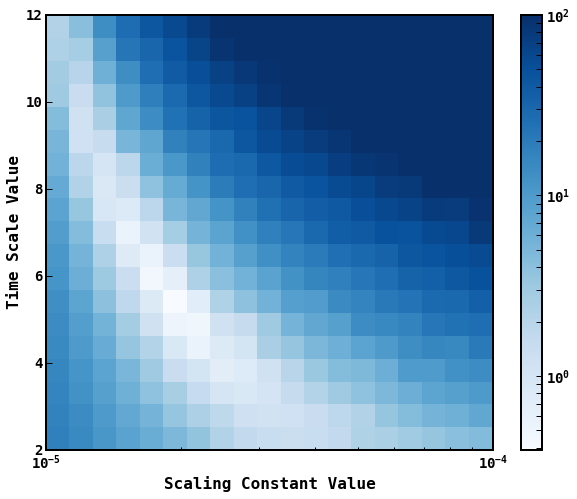

In [123]:
#Slice On background Values:

fig = plt.figure(figsize=(10, 8))

#Slice axis=0, i.e. first loop is removed. Thus no background rate loop
i_min = np.unravel_index(fit_values.argmin(), fit_values.shape)
fit_values_slice=fit_values[i_min[0],:, :]

plt.pcolormesh(scaling_constant_values, time_scale_values, fit_values_slice, vmax=100, norm=LogNorm())
#i_min = np.unravel_index(fit_values.argmin(), fit_values.shape)
plt.colorbar()
#plt.yscale('log')
plt.xscale('log')
plt.xlabel("Scaling Constant Value")
plt.ylabel("Time Scale Value")

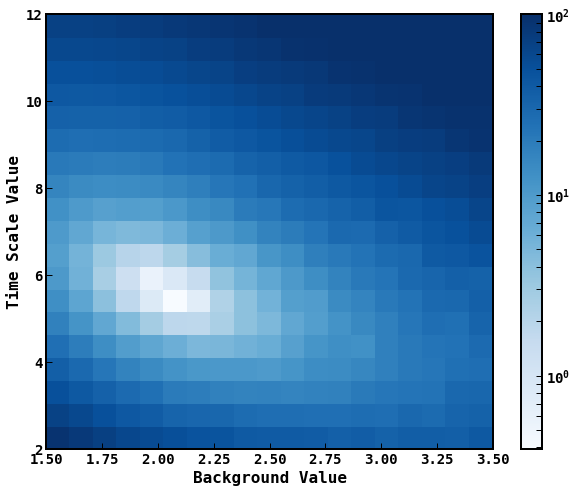

In [113]:
#Slice On background Values:

fig = plt.figure(figsize=(10, 8))

#Slice axis=1, i.e. second loop is removed. Thus no scaling constant loop
i_min = np.unravel_index(fit_values.argmin(), fit_values.shape)
fit_values_slice=fit_values[:, i_min[1] ,:]

plt.pcolormesh(background_values, time_scale_values, fit_values_slice, norm=LogNorm(), vmax=10**2)
#i_min = np.unravel_index(fit_values.argmin(), fit_values.shape)
plt.colorbar()
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel("Background Value")
plt.ylabel("Time Scale Value")

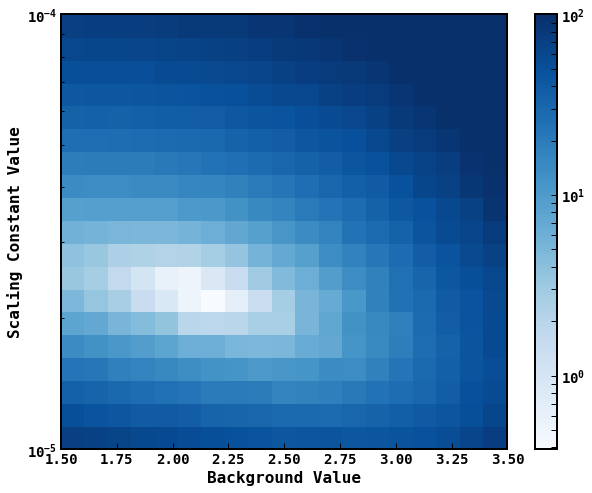

In [114]:
#Slice On background Values:

fig = plt.figure(figsize=(10, 8))

#Slice axis=1, i.e. second loop is removed. Thus no scaling constant loop
i_min = np.unravel_index(fit_values.argmin(), fit_values.shape)
fit_values_slice=fit_values[:, :, i_min[2]]

plt.pcolormesh(background_values, scaling_constant_values, fit_values_slice, norm=LogNorm(), vmax=10**2)
#i_min = np.unravel_index(fit_values.argmin(), fit_values.shape)
plt.colorbar()
plt.yscale('log')
#plt.xscale('log')
plt.xlabel("Background Value")
plt.ylabel("Scaling Constant Value")

### 1D Scans

In [ ]:
#Rate from Data
rate_obs = data_hists_dict['Background']['rate']

#Store fit values for parameter being scanned
time_scale_fits=[]
time_scale_values=np.logspace(-1, 2, 101)

#Settings for ToyMC for other parameters
time_bins=200
window_length=100
source_rate=50
source='Krypton'

for  time_scale in tqdm(time_scale_values):
    #Initialize Bins
    x_bins = [0]*time_bins
    y_bins = [0]*time_bins

    #Run 1000 TImes
    event_rate = source_rate*window_length/1000
    for sim in range(waveforms):
        dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                                background_rate=0, 
                                                time_scale = time_scale,
                                                scaling_constant = 1, 
                                                source = source,
                                                time_bins=time_bins,
                                                window_length = 100)
        y_bins += se_rate/waveforms
    rate_exp = y_bins

    fit_value, fit_probability = scipy.stats.chisquare(rate_obs[4:], rate_exp[4:])
    time_scale_fits.append(fit_value)
    
print (fit_value, fit_probability)

In [ ]:
plt.plot(time_scale_values, np.log10(time_scale_fits))
plt.xlabel("Scaling Constant Value")
plt.ylabel("Log10($\chi^{2}$)")
print("Best fit scaling constant :",  time_scale_values[np.argmin(scaling_constant_fits)])

In [ ]:
plt.plot(scaling_constant_values, np.log10(scaling_constant_fits))
plt.xlabel("Scaling Constant Value")
plt.ylabel("Log10($\chi^{2}$)")
print("Best fit scaling constant :",  scaling_constant_values[np.argmin(scaling_constant_fits)])

In [ ]:
plt.plot(scaling_constant_values, np.log10(scaling_constant_fits))
plt.xlabel("Scaling Constant Value")
plt.ylabel("Log10($\chi^{2}$)")
print("Best fit scaling constant :",  scaling_constant_values[np.argmin(scaling_constant_fits)])

In [ ]:
plt.plot(scaling_constant_values, np.log10(scaling_constant_fits))
plt.xlabel("Scaling Constant Value")
plt.ylabel("Log10($\chi^{2}$)")
print("Best fit scaling constant :",  scaling_constant_values[np.argmin(scaling_constant_fits)])

### Load Results from Reproducibility Study

In [ ]:
scaling_constant_values=np.logspace(-5, -4, 26)
time_scale_values=np.linspace(2, 10, 32)


print('Searching for Processed Pickle Files')
#simpath= '/project/lgrandi/jpienaar/cache_files/'
simpath= '/home/jpienaar/SingleElectrons/processing_scripts/'

#Find datasets
datasets = get_file_list(simpath, 'fitting_results_Background_*', ' ')
print('Found %d datasets' % len(datasets))


all_dicts={}
for dataset in tqdm(datasets[:]):
    with open(simpath+dataset, 'rb') as handle:
        data_dict = pickle.load(handle)
        
        
        
        
        
        all_dicts[dataset]=data_dict
        

In [ ]:
#Average Chi Square values across x fits

fit_values_array=np.array([[0.0]*len(scaling_constant_values)]*len(time_scale_values))
for key, fitting_dict in tqdm(all_dicts.items()):
    tau_bin = np.digitize(fitting_dict['known_tau'], time_scale_values)
    c_bin = np.digitize(fitting_dict['known_c'], scaling_constant_values)
    #fit_values_array[c_bin-1][tau_bin-1] = np.average(fitting_dict['chi'])
    fit_values_array[tau_bin-1][c_bin-1] = np.average(fitting_dict['chi'])
    

fig = plt.figure(figsize=(10, 8))
plt.set_cmap("Blues")
plt.pcolormesh(scaling_constant_values, time_scale_values, fit_values_array, norm=LogNorm())
plt.colorbar()
i_min = np.unravel_index(fit_values_array.argmin(), fit_values_array.shape)
#print("Best fit chisq value :",  fit_values_array[i_min[0]][i_min[1]])
#print("Best fit scaling constant :",  scaling_constant_values[i_min[0]])
print("Best time_scale constant :",  time_scale_values[i_min[1]])
#plt.yscale('log')
plt.xscale('log')
plt.xlabel("Scaling Constant Value")
plt.ylabel("Time Scale Value")


In [ ]:
#Average Error in Tau_Value across 30 Sims

fit_values_array=np.array([[0.0]*len(scaling_constant_values)]*len(time_scale_values))
for key, fitting_dict in tqdm(all_dicts.items()):
    tau_bin = np.digitize(fitting_dict['known_tau'], time_scale_values)
    c_bin = np.digitize(fitting_dict['known_c'], scaling_constant_values)
    average_tau = np.average(fitting_dict['tau'])
    dist_of_taus = np.digitize(average_tau, time_scale_values)-tau_bin                
    #fit_values_array[c_bin-1][tau_bin-1] = dist_of_taus
    fit_values_array[tau_bin-1][c_bin-1] = dist_of_taus
    

fig = plt.figure(figsize=(10, 8))
plt.set_cmap("RdBu")
plt.pcolormesh(scaling_constant_values, time_scale_values, fit_values_array, vmin=-10, vmax=10)#, norm=LogNorm())
plt.colorbar()
i_min = np.unravel_index(fit_values_array.argmin(), fit_values_array.shape)
#print("Best fit chisq value :",  fit_values_array[i_min[0]][i_min[1]])
#print("Best fit scaling constant :",  scaling_constant_values[i_min[0]])
print("Best time_scale constant :",  time_scale_values[i_min[1]])
#plt.yscale('log')
plt.xscale('log')
plt.xlabel("Scaling Constant Value")
plt.ylabel("Time Scale Value")


In [ ]:
#Average Error in C_Value across 30 Sims

fit_values_array=np.array([[0.0]*len(scaling_constant_values)]*len(time_scale_values))
for key, fitting_dict in tqdm(all_dicts.items()):
    tau_bin = np.digitize(fitting_dict['known_tau'], time_scale_values)
    c_bin = np.digitize(fitting_dict['known_c'], scaling_constant_values)
    average_c = np.average(fitting_dict['c'])
    dist_of_cs = np.digitize(average_c, scaling_constant_values)-c_bin                
    #fit_values_array[c_bin-1][tau_bin-1] = dist_of_c
    fit_values_array[tau_bin-1][c_bin-1] = dist_of_cs
    

fig = plt.figure(figsize=(10, 8))
plt.set_cmap("RdBu")
plt.pcolormesh(scaling_constant_values, time_scale_values, fit_values_array, vmin=-5, vmax=5)#, norm=LogNorm())
plt.colorbar()
i_min = np.unravel_index(fit_values_array.argmin(), fit_values_array.shape)
#print("Best fit chisq value :",  fit_values_array[i_min[0]][i_min[1]])
#print("Best fit scaling constant :",  scaling_constant_values[i_min[0]])
print("Best time_scale constant :",  time_scale_values[i_min[1]])
#plt.yscale('log')
plt.xscale('log')
plt.xlabel("Scaling Constant Value")
plt.ylabel("Time Scale Value")


In [ ]:
with open('Background_fitting_MCTruth_results.pkl', 'wb') as handle:
    pickle.dump(all_dicts, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Test Tianyu's Rate

In [84]:
#Load S2 size histograms:
with open('rate.pkl', 'rb') as handle:
    rate_tianyu = pickle.load(handle)

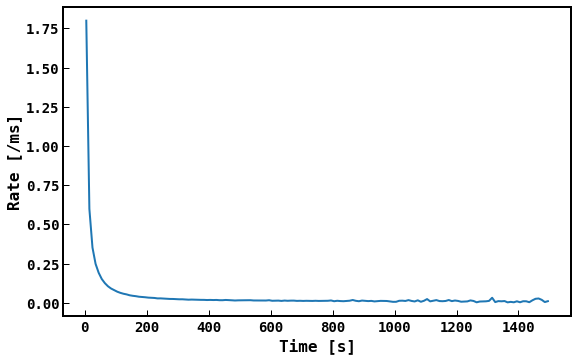

In [86]:
plt.plot(rate_tianyu['bin_centers']*1000, rate_tianyu['rate']/1000, linestyle='-')
plt.xlabel('Time [s]')
plt.ylabel('Rate [/ms]')
#plt.yscale('log')
#plt.xlim([0, 0.1])
plt.show()

In [87]:
from scipy.optimize import curve_fit
from scipy.stats import chisquare

def double_exp(x, a, t_1, b, t_2):
    return a*np.exp(-x/t_1)+b*np.exp(-x/t_2)

def fit_SEs_exp(initial_guess, counts, xcenters):
    #Fit
    popt, pcov = curve_fit(double_exp, xcenters, counts, p0=initial_guess, maxfev=2500)

        
    #Determine chi square
    counts_fitted = double_exp(xcenters, popt[0], popt[1], popt[2], popt[3])
    f_goodness_of_fit = chisquare(counts, counts_fitted)
    fit_plot=plt.plot(xcenters, counts_fitted, linewidth=3, linestyle=':', color='black', label='Fit')
        
        
    return popt


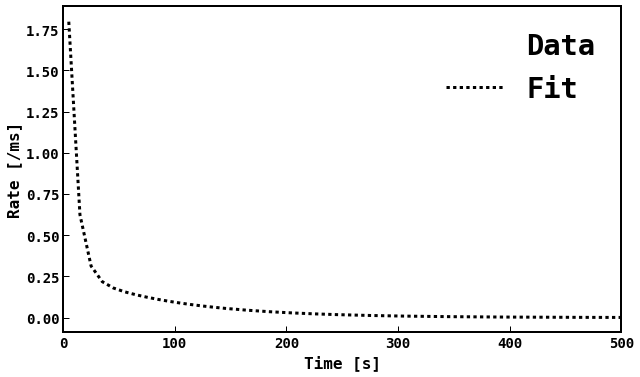

In [88]:
fig=plt.figure(figsize=(10, 6))
initial_guess=(10, 4.5, 2, 100)
plt.plot(rate_tianyu['bin_centers']*1000, rate_tianyu['rate']/1000, linewidth=2, color='red', label='Data')
fit_values = fit_SEs_exp(initial_guess, rate_tianyu['rate'][:]/1000, rate_tianyu['bin_centers'][:]*1000)
plt.xlabel('Time [s]')
plt.ylabel('Rate [/ms]')
plt.legend()
#plt.yscale('log')
plt.xlim([0, 500])
plt.show()

In [89]:
fit_values

array([  3.04526748,   7.21601058,   0.28839343,  88.65886023])

### Split By Date - Bkg

In [ ]:
%%time

bkg_cal_dates=[datetime.date(2017, 1, 17), datetime.date(2017, 3, 1), datetime.date(2017, 4, 1), 
              datetime.date(2017, 5, 1), datetime.date(2017, 6, 1), datetime.date(2017, 7, 1)]

print('Load Data')
simpath= '/project/lgrandi/jpienaar/cache_files/'
#simpath= '/scratch/midway2/jpienaar/cache_files/'

date_label=['Feb', 'Mar', 'Apr', 'May', 'Jun']

#Find datasets
datasets = get_file_list(simpath, '*dt.pkl', ' ')
print('Found %d datasets' % len(datasets))
n_files=len(datasets)

dict_bkg_calibrations={}
for t_index, date in enumerate(bkg_cal_dates[:-1]):
    df=datasets_bkg
    df_temp=hax.cuts.selection(df, df.start>bkg_cal_dates[t_index], 'TimeCut Low')
    df_temp=hax.cuts.selection(df_temp, df_temp.start<bkg_cal_dates[t_index+1], 'TimeCut High')
    dataset_names=df_temp['name']
    dict_calibration={}
    for dataset in tqdm(datasets[:]):
        key=dataset[:-7]
        if dataset_names.isin([dataset[:-7]]).any():
            with open(simpath+dataset, 'rb') as handle:
                data_dict = pickle.load(handle)
                dict_calibration[key]=data_dict
    dict_bkg_calibrations[date_label[t_index]]=dict_calibration

In [ ]:
#Plots corrected event with error added#
colours=['blue', 'orange', 'green', 'magenta', 'cyan', 'red', 'grey', 'black', 'brown']
plt.figure(figsize=(10, 8))
index=0
window_length=10**8
_tpoints=np.linspace(0, window_length, 201)
_xmin=_tpoints[1]
_ymax=1.7e-7
events_hist=0
events=0
index=0

data_hists_dict={}
for source, dict_data in dict_bkg_calibrations.items():
    print(source, len(dict_data))
    del events_hist
    #del livet_hist
    events=0
    for key, data in dict_data.items():
        try:
            events_hist
            events_hist+=data['deltat']
            weight_hist+=data['deltat_weights']
            livet_hist+=data['livet_hist']
            livet_weight+=data['livet_weights']
            events+=data['events']
        except NameError:
            events_hist=data['deltat']
            weight_hist=data['deltat_weights']
            livet_hist=data['livet_hist']
            livet_weight=data['livet_weights']
            events=data['events']
        except KeyError:
            print(source, key)
        
    events_hist=events_hist.sum('s2_area')
    weight_hist=weight_hist.sum('s2_area')
    livet_hist=livet_hist.sum('s2_area')
    livet_weight=livet_weight.sum('s2_area')
    
    #Error
    num_value=np.array(events_hist)
    denum_value=np.array(livet_hist)
    num_error = np.sqrt(weight_hist)
    denum_error = np.sqrt(livet_weight)
    e1 = num_error
    e2 = denum_error
    b1 = num_value
    b2 = denum_value
    w=b1/b2
    
    ratio_error = np.abs(((1-2*w)*e1*e1 + w*w*e2*e2)/(b2*b2))       
    ratio = num_value/denum_value 
    
    #Confidence Bands
    x = _tpoints
    x = np.sort(np.array(list(x[1:]) + list(x[:-1])))
    y1=ratio-np.sqrt(ratio_error)
    y2=ratio+np.sqrt(ratio_error)
    y_lower = np.repeat(y1[:], 2)
    y_upper = np.repeat(y2[:], 2)
        
    #Plot
    plt.step(_tpoints[1:], ratio*1000000, linewidth=3,  color=colours[index], label=source)
    plt.fill_between(x, y_lower*1000000, y_upper*1000000, facecolor=colours[index], interpolate=True, alpha = 0.25)
    
    data_hists_dict[source] = {'rate' : ratio*1000000, 'lower' : y_lower*1000000, 'upper' : y_upper*1000000}
    index+=1
    
    print(events)

plt.xlim([_tpoints[5], _tpoints[-2]])
plt.ylim([1.0, 6])
plt.xlabel('Time Since S2 [ns]', fontsize=12)
plt.ylabel('Corrected Peak Rate [ms$^{-1}$]', fontsize=12)
axes = plt.gca()
axes.tick_params(width=2, length=10)
plt.legend(loc='best', fontsize=12)
#plt.savefig("fig_deltat_example.png", bboxes='tight')
#plt.savefig("fig_deltat_example.pdf", bboxes='tight')
#plt.yscale('log')
plt.show()

In [ ]:
#Store fit values for parameter being scanned
scaling_constant_values = np.logspace(-5.5, -4.5, 26)
#scaling_constant_values = np.linspace(10**-5.5, 10**-4.5, 26)
time_scale_values = np.linspace(4, 18, 40)
#background_rate = np.linspace(0, 4, 25)

waveforms=1000

#Settings for ToyMC for other parameters
time_bins=200 #Needed to match data
window_length=100 #Needed to match data

for key, month in data_hists_dict.items():
    fit_values=[]
    p_values=[]
    
    source='Background'
    source_rate = sampling_dict[source]['event_rate']
    background_rate=2.2

    #Rate from Data
    rate_obs = month['rate']

    for scaling_constant in tqdm(scaling_constant_values):
        temp_array=[]
        temp_p_array=[]
        for  time_scale in time_scale_values:
            #Initialize Bins
            x_bins = [0]*time_bins
            y_bins = [0]*time_bins

            #Run 1000 TImes
            event_rate = source_rate*window_length/1000
            for sim in range(waveforms):
                dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                                        background_rate=background_rate, 
                                                        time_scale = time_scale,
                                                        scaling_constant = scaling_constant, 
                                                        source = source,
                                                        time_bins=time_bins,
                                                        window_length = 100)
                y_bins += se_rate/waveforms
            rate_exp = y_bins

            fit_value, fit_probability = scipy.stats.chisquare(rate_obs[9:198], rate_exp[9:198])
            temp_array = np.append(temp_array, fit_value)
            temp_p_array = np.append(temp_p_array, fit_probability)
        fit_values.append(temp_array)
        p_values.append(temp_p_array)
    fit_values=np.array(fit_values)
    p_values=np.array(p_values)
    
    #Background
    fig = plt.figure(figsize=(10, 8))
    plt.set_cmap("Blues")
    plt.pcolormesh(scaling_constant_values, time_scale_values, fit_values.T, vmax=10**2, norm=LogNorm())
    i_min = np.unravel_index(fit_values.argmin(), fit_values.shape)
    print("Best fit chisq value :",  fit_values[i_min[0]][i_min[1]])
    print("Best fit p-value :",  p_values[i_min[0]][i_min[1]])
    print("Best fit scaling constant :",  scaling_constant_values[i_min[0]])
    print("Best time_scale constant :",  time_scale_values[i_min[1]])
    plt.colorbar()
    #plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("Scaling Constant Value")
    plt.ylabel("Time Scale Value")
    plt.show()

### Split by Date - Rn

In [ ]:
%%time

rn_cal_dates=[datetime.date(2017, 1, 17), datetime.date(2017, 4, 1), datetime.date(2017, 6, 1), 
              datetime.date(2017, 7, 1), datetime.date(2017, 8, 1), datetime.date(2017, 9, 1)]

print('Load Data')
simpath= '/project/lgrandi/jpienaar/cache_files/'
#simpath= '/scratch/midway2/jpienaar/cache_files/'

date_label=["13 Mar", "9 May", "12 Jun", "10 Jul", "7 Aug"]

#Find datasets
datasets = get_file_list(simpath, '*dt.pkl', ' ')
print('Found %d datasets' % len(datasets))
n_files=len(datasets)

dict_rn_calibrations={}
for t_index, date in enumerate(rn_cal_dates[:-1]):
    df=datasets_rn
    df_temp=hax.cuts.selection(df, df.start>rn_cal_dates[t_index], 'TimeCut Low')
    df_temp=hax.cuts.selection(df_temp, df_temp.start<rn_cal_dates[t_index+1], 'TimeCut High')
    dataset_names=df_temp['name']
    dict_calibration={}
    for dataset in tqdm(datasets[:]):
        key=dataset[:-7]
        if dataset_names.isin([dataset[:-7]]).any():
            with open(simpath+dataset, 'rb') as handle:
                data_dict = pickle.load(handle)
                dict_calibration[key]=data_dict
    dict_rn_calibrations[date_label[t_index]]=dict_calibration

In [ ]:
#Plots corrected event with error added#
colours=['blue', 'orange', 'green', 'magenta', 'cyan', 'red', 'grey', 'black', 'brown']
plt.figure(figsize=(10, 8))
index=0
window_length=10**8
_tpoints=np.linspace(0, window_length, 201)
_xmin=_tpoints[1]
_ymax=1.7e-7
events_hist=0
events=0
index=0

data_hists_dict={}
for source, dict_data in dict_rn_calibrations.items():
    print(source, len(dict_data))
    del events_hist
    #del livet_hist
    events=0
    for key, data in dict_data.items():
        try:
            events_hist
            events_hist+=data['deltat']
            weight_hist+=data['deltat_weights']
            livet_hist+=data['livet_hist']
            livet_weight+=data['livet_weights']
            events+=data['events']
        except NameError:
            events_hist=data['deltat']
            weight_hist=data['deltat_weights']
            livet_hist=data['livet_hist']
            livet_weight=data['livet_weights']
            events=data['events']
        except KeyError:
            print(source, key)
        
    events_hist=events_hist.sum('s2_area')
    weight_hist=weight_hist.sum('s2_area')
    livet_hist=livet_hist.sum('s2_area')
    livet_weight=livet_weight.sum('s2_area')
    
    #Error
    num_value=np.array(events_hist)
    denum_value=np.array(livet_hist)
    num_error = np.sqrt(weight_hist)
    denum_error = np.sqrt(livet_weight)
    e1 = num_error
    e2 = denum_error
    b1 = num_value
    b2 = denum_value
    w=b1/b2
    
    ratio_error = np.abs(((1-2*w)*e1*e1 + w*w*e2*e2)/(b2*b2))       
    ratio = num_value/denum_value 
    
    #Remove problematic time around HV energy veto.
    #ratio[18]=np.nan
    #ratio[19]=np.nan
    #ratio[20]=np.nan
    #ratio[21]=np.nan
    #ratio_error[18]=np.nan
    #ratio_error[19]=np.nan
    #ratio_error[20]=np.nan
    #ratio_error[21]=np.nan
    
    #Confidence Bands
    x = _tpoints
    x = np.sort(np.array(list(x[1:]) + list(x[:-1])))
    y1=ratio-np.sqrt(ratio_error)
    y2=ratio+np.sqrt(ratio_error)
    y_lower = np.repeat(y1[:], 2)
    y_upper = np.repeat(y2[:], 2)
        
    #Plot
    plt.step(_tpoints[1:], ratio*1000000, linewidth=3,  color=colours[index], label=source)
    plt.fill_between(x, y_lower*1000000, y_upper*1000000, facecolor=colours[index], interpolate=True, alpha = 0.25)
    
    data_hists_dict[source] = {'rate' : ratio*1000000, 'lower' : y_lower*1000000, 'upper' : y_upper*1000000}
    
    index+=1
    
    print(events)

plt.xlim([_tpoints[5], _tpoints[-2]])
plt.ylim([3.2, 7.5])
plt.xlabel('Time Since S2 [ns]', fontsize=12)
plt.ylabel('Corrected Peak Rate [ms$^{-1}$]', fontsize=12)
axes = plt.gca()
axes.tick_params(width=2, length=10)
plt.legend(loc='best', fontsize=12)
#plt.savefig("fig_deltat_example.png", bboxes='tight')
#plt.savefig("fig_deltat_example.pdf", bboxes='tight')
#plt.yscale('log')
plt.show()

In [ ]:
#Store fit values for parameter being scanned
scaling_constant_values = np.logspace(-5.5, -4.5, 26)
#scaling_constant_values = np.linspace(10**-5.5, 10**-4.5, 26)
time_scale_values = np.linspace(14, 26, 36)
#background_rate = np.linspace(0, 4, 25)

waveforms=1000

#Settings for ToyMC for other parameters
time_bins=200 #Needed to match data
window_length=100 #Needed to match data

for key, month in data_hists_dict.items():
    fit_values=[]
    p_values=[]
    
    source='Radon'
    source_rate = sampling_dict[source]['event_rate']
    background_rate=3.2

    #Rate from Data
    rate_obs = month['rate']

    for scaling_constant in tqdm(scaling_constant_values):
        temp_array=[]
        temp_p_array=[]
        for  time_scale in time_scale_values:
            #Initialize Bins
            x_bins = [0]*time_bins
            y_bins = [0]*time_bins

            #Run 1000 TImes
            event_rate = source_rate*window_length/1000
            for sim in range(waveforms):
                dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                                        background_rate=background_rate, 
                                                        time_scale = time_scale,
                                                        scaling_constant = scaling_constant, 
                                                        source = source,
                                                        time_bins=time_bins,
                                                        window_length = 100)
                y_bins += se_rate/waveforms
            rate_exp = y_bins

            # For Radon data:
            rate_obs = month['rate']
            rate_exp=np.append(rate_exp[0:18], rate_exp[22:])
            rate_obs=np.append(rate_obs[0:18], rate_obs[22:])
            
            #Chi-square value
            fit_value, fit_probability = scipy.stats.chisquare(rate_obs[9:198], rate_exp[9:198])
            temp_array = np.append(temp_array, fit_value)
            temp_p_array = np.append(temp_p_array, fit_probability)
        fit_values.append(temp_array)
        p_values.append(temp_p_array)
    fit_values=np.array(fit_values)
    p_values=np.array(p_values)
    
    #Background
    fig = plt.figure(figsize=(10, 8))
    plt.set_cmap("Blues")
    plt.pcolormesh(scaling_constant_values, time_scale_values, fit_values.T, norm=LogNorm(), vmax=10**2)
    i_min = np.unravel_index(fit_values.argmin(), fit_values.shape)
    print("Best fit chisq value :",  fit_values[i_min[0]][i_min[1]])
    print("Best fit p-value :",  p_values[i_min[0]][i_min[1]])
    print("Best fit scaling constant :",  scaling_constant_values[i_min[0]])
    print("Best time_scale constant :",  time_scale_values[i_min[1]])
    plt.colorbar()
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("Scaling Constant Value")
    plt.ylabel("Time Scale Value")
    plt.show()